# EMBED Dataset Filtering

This notebook contains guidance on filtering EMBED by the following features:
- Patient Race/Ethnicity
- Patient Age
- Breast Density
- Invasive vs Non-Invasive Cancers
- BIRADs assessment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import tableone
from tqdm import tqdm

In [158]:
def dataframe_stats(df):
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")
        
def plot_feature_density(feature, depth: int = 1, cmap: str = 'viridis'):
    # get colormap object
    cm = plt.get_cmap(cmap)
    
    # create the density plot
    axis = feature.plot.density(
        xlim=(feature.min(), feature.max()), 
        color=cm(0.0)
    )

    # get mean and standard deviation for age
    var_mean = feature.mean()
    var_std = feature.std()

    line = axis.get_lines()[0]

    # extract x and y data from the line object
    x = line.get_xdata()
    y = line.get_ydata()
    
    # plot mean
    axis.axvline(var_mean, color=cm(1.0), linestyle='--', label='Mean')
    
    # iterate over std depth levels
    for i in range(depth, 0, -1):
        # get bounds of std interval
        sigma_min, sigma_max = var_mean-(i*var_std), var_mean+(i*var_std)
        
        # mask array between bounds
        array_mask = (x >= sigma_min) & (x <= sigma_max)
        
        # plot std interval
        sigma_value = 0.7 / i
        axis.fill_between(x, y, where=array_mask, color=cm(sigma_value), alpha=0.3, label=f'{i}σ')
        
    ax.legend()
        
    return axis

In [28]:
base_directory = "/data/beatrice/emory_datathon/embed_upload"
mag_path = base_directory + "/tables/embed_datathon_magview_reduced.csv"
meta_path = base_directory + "/tables/embed_datathon_metadata_full.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
print(f"Magview:")
dataframe_stats(mag_df)

# load image metadata
meta_df = pd.read_csv(meta_path)
print(f"Metadata:")
dataframe_stats(meta_df)

Magview:
Patients: 115883
Exams: 364733


/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (74,103,104,113,114,115,116,117,118,119,121,128,130,131,132,133,134,136,141,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Metadata:
Patients: 115894
Exams: 364733
Images: 2403687


---
## Patient Race and Ethnicity

EMBED has two demographic variables containing the race and ethnicity of patients:
- ETHNICITY_DESC: This variable contains the self-identified race of the patient. The category 'Hispanic' is present, but this is unreliable and the 'Hispanic or Latino' label of ETHNICITY_GROUP_DESC should be used to index Hispanic patients instead.
- ETHNICITY_GROUP_DESC: This variable contains the self-identified ethnicity of the patient. It is less clean than ETHNICITY_DESC and will require processing for use in analysis.

The dataset has a fairly even racial balance between Black and white patients, but other racial categories have significantly fewer patients. Depending on the desired analysis it may be necessary to consolidate these categories.

In [24]:
categorical_cols = ['ETHNICITY_DESC', 'ETHNIC_GROUP_DESC']
tableone(mag_df, categorical_cols)

Missing        Overall
n                                                                                  408464
ETHNICITY_DESC, n (%)    African American  or Black                   1016  180922 (44.4)
                         American Indian or Alaskan Native                      846 (0.2)
                         Asian                                                21365 (5.2)
                         Caucasian or White                                 171948 (42.2)
                         Hispanic                                                34 (0.0)
                         Multiple                                              1307 (0.3)
                         Native Hawaiian or Other Pacific Islander             3835 (0.9)
                         Not Recorded                                            32 (0.0)
                         Patient Declines                                        20 (0.0)
                         Unknown, Unavailable or Unreported                   27139 (6.7)
ETHNIC_GROUP_DESC, n (%) CD:1231368306                                1016        2 (0.0)
                         CD:1565395161                                           31 (0.0)
                         CD:1565528481                                            3 (0.0)
                         CD:1641210453                                           21 (0.0)
                         CD:1702624199                                            1 (0.0)
                         CD:1719092855                                           14 (0.0)
                         CD:1793397901                                            1 (0.0)
                         CD:1808060937                                            2 (0.0)
                         CD:1847885097                                            5 (0.0)
                         CD:1858666135                                           41 (0.0)
                         CD:1862937909                                            6 (0.0)
                         CD:1902530759                                            1 (0.0)
                         CD:2100170165                                            6 (0.0)
                         CD:2112660279                                            3 (0.0)
                         CD:2264735701                                            1 (0.0)
                         CD:2268368555                                            2 (0.0)
                         Hispanic or Latino                                   19933 (4.9)
                         Non-Hispanic or Latino                             328421 (80.6)
                         Non-Hispanic~Unknown                                   159 (0.0)
                         Not Recorded                                          4133 (1.0)
                         Unknown~Hispanic                                        55 (0.0)
                         Unknown~Non-Hispanic                                   331 (0.1)
                         Unreported, Unknown, Unavailable                    54276 (13.3)

### Code Patient Race

In [34]:
# create the 'patient_race' column and set the default value to 'Unknown'
mag_df.loc[:, 'patient_race'] = 'Unknown'

# code races for Black and white patients
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'African American  or Black', 'patient_race'] = 'Black'
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'Caucasian or White', 'patient_race'] = 'White'

# consolidate other patient race categories
other_race_categories = [
    'American Indian or Alaskan Native', 
    'Asian', 
    'Hispanic', 
    'Multiple', 
    'Native Hawaiian or Other Pacific Islander'
]
mag_df.loc[mag_df['ETHNICITY_DESC'].isin(other_race_categories), 'patient_race'] = 'Other'

In [35]:
tableone(mag_df, ['ETHNICITY_DESC'], groupby=['patient_race'])

Grouped by patient_race                                                                           
                                                                                Missing        Overall           Black         Other       Unknown           White
n                                                                                               408464          180922         27387         28207          171948
ETHNICITY_DESC, n (%) African American  or Black                                   1016  180922 (44.4)  180922 (100.0)                                            
                      American Indian or Alaskan Native                                      846 (0.2)                     846 (3.1)                              
                      Asian                                                                21365 (5.2)                  21365 (78.0)                              
                      Caucasian or White                                                 171948 (42.2)                                              171948 (100.0)
                      Hispanic                                                                34 (0.0)                      34 (0.1)                              
                      Multiple                                                              1307 (0.3)                    1307 (4.8)                              
                      Native Hawaiian or Other Pacific Islander                             3835 (0.9)                   3835 (14.0)                              
                      Not Recorded                                                            32 (0.0)                                    32 (0.1)                
                      Patient Declines                                                        20 (0.0)                                    20 (0.1)                
                      Unknown, Unavailable or Unreported                                   27139 (6.7)                                27139 (99.8)

### Code Patient Ethnicity

In [36]:
# create the 'patient_ethnicity' column and set the default value to 'Unknown'
mag_df.loc[:, 'patient_ethnicity'] = 'Unknown'

# code hispanic or latino patient ethnicity categories
hispanic_categories = [
    'Hispanic or Latino', 
    'Unknown~Hispanic', 
]
mag_df.loc[mag_df['ETHNIC_GROUP_DESC'].isin(hispanic_categories), 'patient_ethnicity'] = 'Hispanic'

# code non-hispanic or latino patient ethnicity categories
non_hispanic_categories = [
    'Non-Hispanic or Latino', 
    'Non-Hispanic~Unknown', 
    'Unknown~Non-Hispanic', 
]
mag_df.loc[mag_df['ETHNIC_GROUP_DESC'].isin(non_hispanic_categories), 'patient_ethnicity'] = 'Not Hispanic'

In [37]:
tableone(mag_df, ['ETHNIC_GROUP_DESC'], groupby=['patient_ethnicity'])

Grouped by patient_ethnicity                                                          
                                                                               Missing        Overall      Hispanic   Not Hispanic       Unknown
n                                                                                              408464         19988         328911         59565
ETHNIC_GROUP_DESC, n (%) CD:1231368306                                            1016        2 (0.0)                                    2 (0.0)
                         CD:1565395161                                                       31 (0.0)                                   31 (0.1)
                         CD:1565528481                                                        3 (0.0)                                    3 (0.0)
                         CD:1641210453                                                       21 (0.0)                                   21 (0.0)
                         CD:1702624199                                                        1 (0.0)                                    1 (0.0)
                         CD:1719092855                                                       14 (0.0)                                   14 (0.0)
                         CD:1793397901                                                        1 (0.0)                                    1 (0.0)
                         CD:1808060937                                                        2 (0.0)                                    2 (0.0)
                         CD:1847885097                                                        5 (0.0)                                    5 (0.0)
                         CD:1858666135                                                       41 (0.0)                                   41 (0.1)
                         CD:1862937909                                                        6 (0.0)                                    6 (0.0)
                         CD:1902530759                                                        1 (0.0)                                    1 (0.0)
                         CD:2100170165                                                        6 (0.0)                                    6 (0.0)
                         CD:2112660279                                                        3 (0.0)                                    3 (0.0)
                         CD:2264735701                                                        1 (0.0)                                    1 (0.0)
                         CD:2268368555                                                        2 (0.0)                                    2 (0.0)
                         Hispanic or Latino                                               19933 (4.9)  19933 (99.7)                             
                         Non-Hispanic or Latino                                         328421 (80.6)                328421 (99.9)              
                         Non-Hispanic~Unknown                                               159 (0.0)                    159 (0.0)              
                         Not Recorded                                                      4133 (1.0)                                 4133 (7.1)
                         Unknown~Hispanic                                                    55 (0.0)      55 (0.3)                             
                         Unknown~Non-Hispanic                                               331 (0.1)                    331 (0.1)              
                         Unreported, Unknown, Unavailable                                54276 (13.3)                               54276 (92.7)

In [38]:
tableone(mag_df, ['patient_race'], groupby=['patient_ethnicity'])

Grouped by patient_ethnicity                                                         
                                                 Missing        Overall     Hispanic   Not Hispanic       Unknown
n                                                                408464        19988         328911         59565
patient_race, n (%) Black                              0  180922 (44.3)   1529 (7.6)  156122 (47.5)  23271 (39.1)
                    Other                                   27387 (6.7)  3408 (17.1)    21637 (6.6)    2342 (3.9)
                    Unknown                                 28207 (6.9)  8319 (41.6)     5072 (1.5)  14816 (24.9)
                    White                                 171948 (42.1)  6732 (33.7)  146080 (44.4)  19136 (32.1)

The following is example code to build a dataset of screening mammograms for a classification model to predict a patient's race. For this example, images from Black patients will be considered the positive class while images from white patients will be considered the negative class.

In [39]:
# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# get dataframe of screening exams for African American and/or Black patients
mag_scr_pos_df = mag_scr_df[mag_scr_df['patient_race'] == 'Black']

# get dataframe of screening exams for Caucasian and/or white patients
mag_scr_neg_df = mag_scr_df[mag_scr_df['patient_race'] == 'White']

In [42]:
tableone(mag_scr_pos_df, ['patient_race'])

,,Missing,Overall
n,,,127985
"patient_race, n (%)",Black,0,127985 (100.0)


In [43]:
tableone(mag_scr_neg_df, ['patient_race'])

,,Missing,Overall
n,,,127336
"patient_race, n (%)",White,0,127336 (100.0)


In [ ]:
# FINISH THIS SECTION

---
## Patient Age

In [47]:
mag_df['age_at_study'].describe()

count    407448.000000
mean         58.520519
std          12.065398
min          15.504767
25%          48.925714
50%          58.155883
75%          67.538690
max          89.000000
Name: age_at_study, dtype: float64

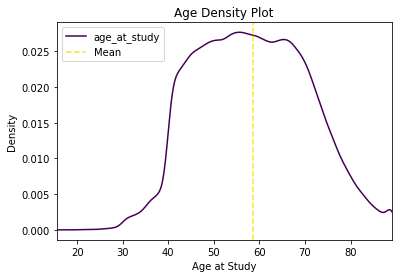

In [163]:
ax = plot_feature_density(mag_df['age_at_study'], depth=0, cmap='viridis')

# Add legend and title
ax.set_title('Age Density Plot')
ax.set_xlabel('Age at Study')
ax.legend()

plt.show()

In [73]:
# Convert the continuous age into a categorical variable with 10 bins
# find minimum age and offset
min_age = mag_df['age_at_study'].min()
min_age_offset = min_age % 10

# find maximum age and offset
max_age = mag_df['age_at_study'].max()
max_age_offset = 10 - (max_age % 10)

# create variable bins and bin labels
bins = [i for i in range(int(min_age - min_age_offset), int(max_age + max_age_offset + 1), 10)]
labels = [f"{i}-{i+10}" for i in bins[:-1]]

# create new 'age_bins' column and split 'age_at_study' into bins
mag_df['age_bins'] = pd.cut(mag_df['age_at_study'], bins=bins, labels=labels, right=False)

In [76]:
# inspect new bins
tableone(mag_df, ['age_at_study'], groupby=['age_bins'])

Grouped by age_bins                                                                                                             
                                     Missing      Overall       10-20       20-30       30-40       40-50       50-60       60-70       70-80       80-90
n                                                  408464          10         648       14343       98386      110822      106201       61082       15956
age_at_study, mean (SD)                 1016  58.5 (12.1)  18.4 (1.3)  27.4 (2.3)  36.2 (2.7)  45.2 (2.9)  55.0 (2.9)  64.9 (2.9)  74.1 (2.8)  84.0 (2.9)

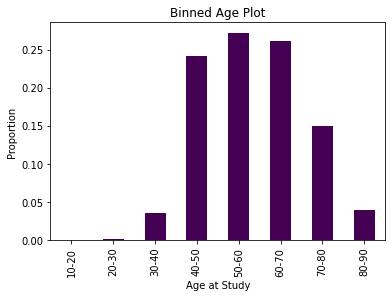

In [164]:
ax = mag_df['age_bins'].value_counts(normalize=True).sort_index().plot(kind='bar', cmap='viridis')

ax.set_xlabel('Age at Study')
ax.set_ylabel('Proportion')
ax.set_title('Binned Age Plot')

plt.show()

---
## Breast Density

---
## Invasive vs Non-Invasive Cancers

---
## Breast Density